In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder # sklearn: Various functions for preprocessing, training, and evaluating ML models.
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb #gradient boosting library.
from xgboost import plot_importance

In [3]:
df=pd.read_csv('./data/CICIDS2017_sample_km.csv')

In [4]:
X = df.drop(['Label'],axis=1).values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [6]:
#Compute Feature Importance Using Mutual Information
# The result (importances) gives a measure of how much each feature contributes to predicting the target.
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X_train, y_train)

In [7]:
# Z-score normalization
# ensures all numerical features have zero mean and unit variance, making them comparable.
features = df.dtypes[df.dtypes != 'object'].index
df[features] = df[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# Fill empty values by 0
df = df.fillna(0)

In [8]:
# calculate the sum of importance scores
#Rank Features by Importance
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
# Accumulates feature importance scores in Sum and tores selected feature names in fs
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [9]:
# select the important features from top to bottom until the accumulated importance reaches 90%
# Selecting Features until 90% Importance is Achieved
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break        

In [10]:
#Extract the Final Selected Features
X_fs = df[fs].values

In [11]:
X_fs.shape

(26800, 44)

In [12]:
import sys
sys.path.append("D:\MNIT Jaipur\Sem 2\STL Lab\Anamoly\FCBF\FCBF_module")  # Change this to the actual folder path
from FCBF_module import FCBF, FCBFK, FCBFiP, get_i
fcbf = FCBFK(k = 20)
#fcbf.fit(X_fs, y)

In [13]:
X_fss = fcbf.fit_transform(X_fs,y)

In [14]:
X_fss.shape

(26800, 20)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_fss,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [16]:
X_train.shape

(21440, 20)

In [17]:
pd.Series(y_train).value_counts()

0    14580
3     2433
6     1744
1     1573
5     1004
2       77
4       29
Name: count, dtype: int64

In [18]:
from imblearn.over_sampling import SMOTENC
# categorical_features=[0, 1, 2] : Specifies that columns 0, 1, and 2 contain categorical data, which SMOTENC 
# will handle differently from numerical data.
# sampling_strategy={2: 1000, 4: 1000} :  classes 2 and 4 will be oversampled to 1000 instances each.
# Increases the number of samples in the imbalanced classes (2 and 4) by synthetically generating new data point
smote = SMOTENC(categorical_features=[0, 1, 2], sampling_strategy={2: 1000, 4: 1000})


In [19]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [20]:
pd.Series(y_train).value_counts()

0    14580
3     2433
6     1744
1     1573
5     1004
4     1000
2     1000
Name: count, dtype: int64

Accuracy of XGBoost: 0.9914179104477612
Precision of XGBoost: 0.9914471966410269
Recall of XGBoost: 0.9914179104477612
F1-score of XGBoost: 0.9914106891048661
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3645
           1       0.98      0.99      0.99       393
           2       1.00      1.00      1.00        19
           3       0.99      0.99      0.99       609
           4       0.83      0.71      0.77         7
           5       0.98      1.00      0.99       251
           6       0.97      0.99      0.98       436

    accuracy                           0.99      5360
   macro avg       0.97      0.95      0.96      5360
weighted avg       0.99      0.99      0.99      5360



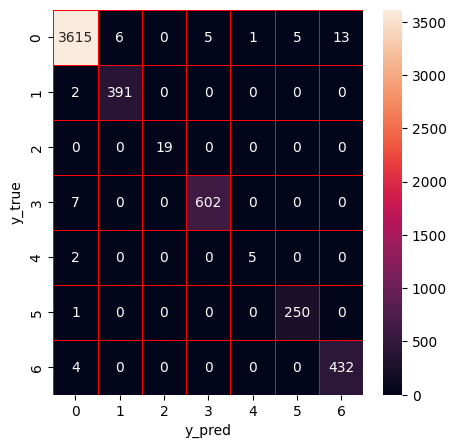

In [21]:
#Trains an XGBoost classifier on the dataset and evaluates 
# its performance using accuracy, precision, recall, F1-score, and a confusion matrix.
xg = xgb.XGBClassifier(n_estimators = 10) #  Creates an XGBoost model with 10 decision trees
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [22]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|███████████████████████████████████████████████| 20/20 [00:19<00:00,  1.02trial/s, best loss: -0.9968283582089552]
XGBoost: Hyperopt estimated optimum {'learning_rate': -0.7455436174275478, 'max_depth': 77.0, 'n_estimators': 100.0}


Accuracy of XGBoost: 0.9960820895522388
Precision of XGBoost: 0.9960961829243252
Recall of XGBoost: 0.9960820895522388
F1-score of XGBoost: 0.9960540794838951
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3645
           1       0.99      1.00      0.99       393
           2       1.00      1.00      1.00        19
           3       1.00      1.00      1.00       609
           4       1.00      0.71      0.83         7
           5       0.99      1.00      0.99       251
           6       0.99      0.99      0.99       436

    accuracy                           1.00      5360
   macro avg       0.99      0.96      0.97      5360
weighted avg       1.00      1.00      1.00      5360



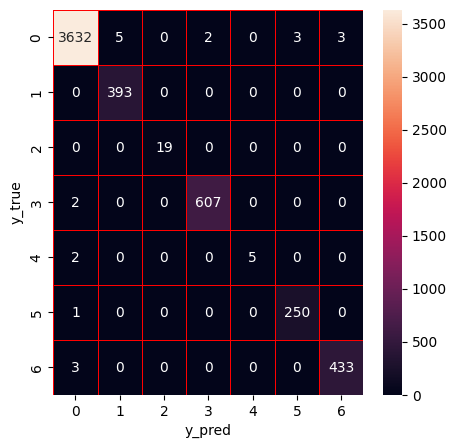

In [23]:
xg = xgb.XGBClassifier(learning_rate= 0.7340229699980686, n_estimators = 70, max_depth = 14)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [24]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

Accuracy of RF: 0.9949626865671641
Precision of RF: 0.9949829521306102
Recall of RF: 0.9949626865671641
F1-score of RF: 0.9949367492813334
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3645
           1       0.99      1.00      1.00       393
           2       1.00      1.00      1.00        19
           3       0.99      1.00      1.00       609
           4       1.00      0.71      0.83         7
           5       0.98      1.00      0.99       251
           6       0.98      0.99      0.99       436

    accuracy                           0.99      5360
   macro avg       0.99      0.96      0.97      5360
weighted avg       0.99      0.99      0.99      5360



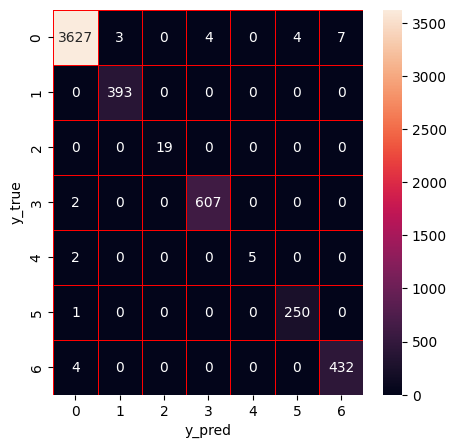

In [25]:
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train) 
rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [26]:
# Hyperparameter optimization of random forest
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = RandomForestClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|███████████████████████████████████████████████| 20/20 [02:26<00:00,  7.34s/trial, best loss: -0.9949626865671641]
Random Forest: Hyperopt estimated optimum {'criterion': 1, 'max_depth': 42.0, 'max_features': 13.0, 'min_samples_leaf': 2.0, 'min_samples_split': 3.0, 'n_estimators': 167.0}


Accuracy of RF: 0.9938432835820895
Precision of RF: 0.9938743210803681
Recall of RF: 0.9938432835820895
F1-score of RF: 0.9938196510070099
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3645
           1       0.99      1.00      0.99       393
           2       1.00      1.00      1.00        19
           3       0.99      0.99      0.99       609
           4       1.00      0.71      0.83         7
           5       0.98      1.00      0.99       251
           6       0.98      0.99      0.99       436

    accuracy                           0.99      5360
   macro avg       0.99      0.96      0.97      5360
weighted avg       0.99      0.99      0.99      5360



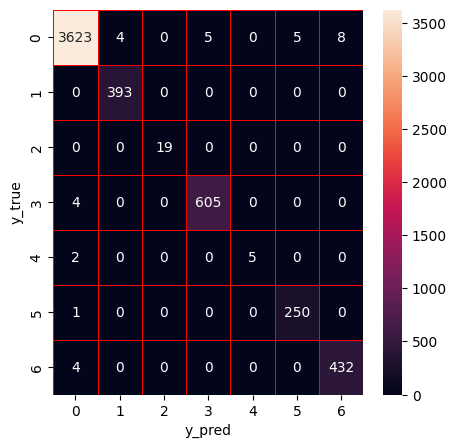

In [27]:
rf_hpo = RandomForestClassifier(n_estimators = 71, min_samples_leaf = 1, max_depth = 46, min_samples_split = 9, max_features = 20, criterion = 'entropy')
rf_hpo.fit(X_train,y_train)
rf_score=rf_hpo.score(X_test,y_test)
y_predict=rf_hpo.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [28]:
rf_train=rf_hpo.predict(X_train)
rf_test=rf_hpo.predict(X_test)

Accuracy of DT: 0.9940298507462687
Precision of DT: 0.9942577634788267
Recall of DT: 0.9940298507462687
F1-score of DT: 0.9941261805508536
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3645
           1       0.99      1.00      0.99       393
           2       1.00      1.00      1.00        19
           3       1.00      1.00      1.00       609
           4       0.44      0.57      0.50         7
           5       0.98      1.00      0.99       251
           6       0.98      0.99      0.99       436

    accuracy                           0.99      5360
   macro avg       0.91      0.94      0.92      5360
weighted avg       0.99      0.99      0.99      5360



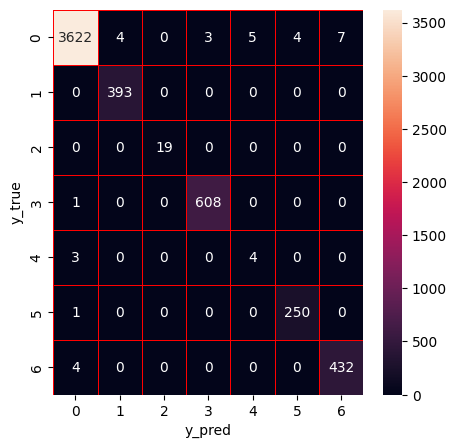

In [29]:
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train) 
dt_score=dt.score(X_test,y_test)
y_predict=dt.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [30]:
# Hyperparameter optimization of decision tree
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = DecisionTreeClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)
print("Decision tree: Hyperopt estimated optimum {}".format(best))

100%|███████████████████████████████████████████████| 50/50 [00:06<00:00,  8.31trial/s, best loss: -0.9944029850746269]
Decision tree: Hyperopt estimated optimum {'criterion': 0, 'max_depth': 50.0, 'max_features': 20.0, 'min_samples_leaf': 1.0, 'min_samples_split': 9.0}


Accuracy of DT: 0.9932835820895523
Precision of DT: 0.9933567918034031
Recall of DT: 0.9932835820895523
F1-score of DT: 0.9933061124246153
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3645
           1       0.99      1.00      1.00       393
           2       0.95      1.00      0.97        19
           3       1.00      1.00      1.00       609
           4       0.62      0.71      0.67         7
           5       0.98      1.00      0.99       251
           6       0.99      0.97      0.98       436

    accuracy                           0.99      5360
   macro avg       0.93      0.95      0.94      5360
weighted avg       0.99      0.99      0.99      5360



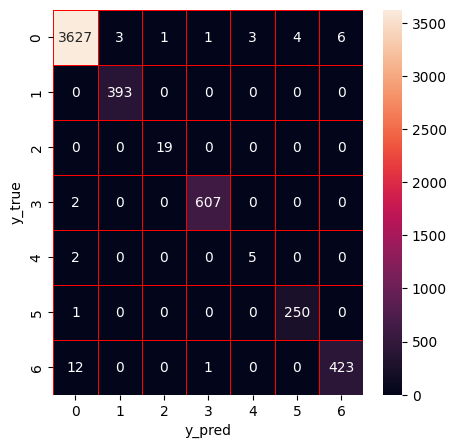

In [31]:
dt_hpo = DecisionTreeClassifier(min_samples_leaf = 2, max_depth = 47, min_samples_split = 3, max_features = 19, criterion = 'gini')
dt_hpo.fit(X_train,y_train)
dt_score=dt_hpo.score(X_test,y_test)
y_predict=dt_hpo.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [32]:
dt_train=dt_hpo.predict(X_train)
dt_test=dt_hpo.predict(X_test)

Accuracy of ET: 0.9949626865671641
Precision of ET: 0.9949724901205317
Recall of ET: 0.9949626865671641
F1-score of ET: 0.9949328271046207
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3645
           1       0.99      1.00      1.00       393
           2       1.00      1.00      1.00        19
           3       0.99      0.99      0.99       609
           4       1.00      0.71      0.83         7
           5       0.98      1.00      0.99       251
           6       1.00      0.99      0.99       436

    accuracy                           0.99      5360
   macro avg       0.99      0.96      0.97      5360
weighted avg       0.99      0.99      0.99      5360



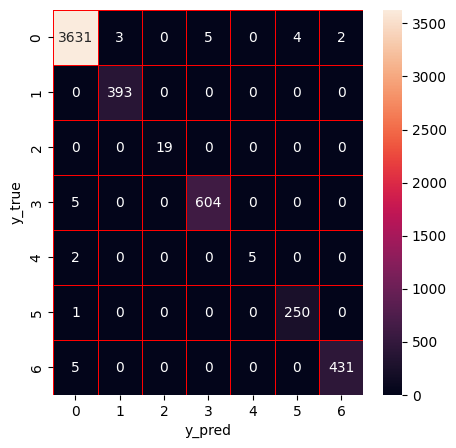

In [33]:
et = ExtraTreesClassifier(random_state = 0)
et.fit(X_train,y_train) 
et_score=et.score(X_test,y_test)
y_predict=et.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [34]:
# Hyperparameter optimization of extra trees
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = ExtraTreesClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|███████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/trial, best loss: -0.9929104477611941]
Random Forest: Hyperopt estimated optimum {'criterion': 1, 'max_depth': 30.0, 'max_features': 19.0, 'min_samples_leaf': 3.0, 'min_samples_split': 8.0, 'n_estimators': 105.0}


Accuracy of ET: 0.9953358208955224
Precision of ET: 0.9953553190053256
Recall of ET: 0.9953358208955224
F1-score of ET: 0.9953088918718146
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3645
           1       0.99      1.00      0.99       393
           2       1.00      1.00      1.00        19
           3       0.99      1.00      0.99       609
           4       1.00      0.71      0.83         7
           5       0.98      1.00      0.99       251
           6       1.00      0.99      0.99       436

    accuracy                           1.00      5360
   macro avg       0.99      0.96      0.97      5360
weighted avg       1.00      1.00      1.00      5360



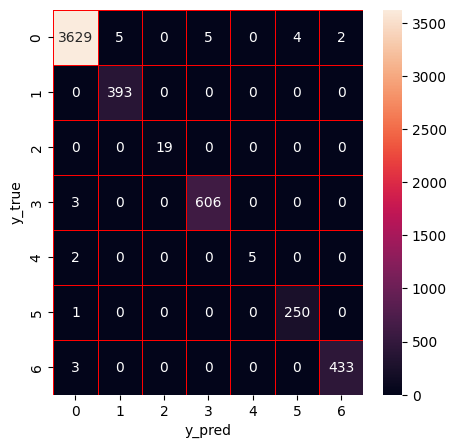

In [35]:
et_hpo = ExtraTreesClassifier(n_estimators = 53, min_samples_leaf = 1, max_depth = 31, min_samples_split = 5, max_features = 20, criterion = 'entropy')
et_hpo.fit(X_train,y_train) 
et_score=et_hpo.score(X_test,y_test)
y_predict=et_hpo.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [36]:
et_train=et_hpo.predict(X_train)
et_test=et_hpo.predict(X_test)

In [37]:
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,0,0,0,0
1,0,0,0,0
2,1,1,1,1
3,0,0,0,0
4,3,3,3,3


In [38]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [39]:
dt_train.shape

(23334, 1)

In [40]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

Accuracy of Stacking: 0.9951492537313433
Precision of Stacking: 0.9951680448024112
Recall of Stacking: 0.9951492537313433
F1-score of Stacking: 0.9951218171684926
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3645
           1       0.99      1.00      0.99       393
           2       1.00      1.00      1.00        19
           3       0.99      1.00      0.99       609
           4       1.00      0.71      0.83         7
           5       0.98      1.00      0.99       251
           6       1.00      0.99      0.99       436

    accuracy                           1.00      5360
   macro avg       0.99      0.96      0.97      5360
weighted avg       1.00      1.00      1.00      5360



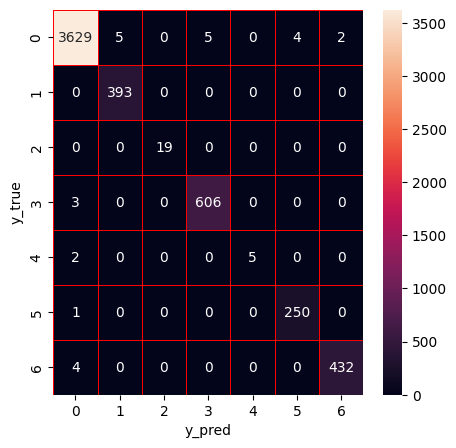

In [41]:
stk = xgb.XGBClassifier().fit(x_train, y_train)
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [42]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|███████████████████████████████████████████████| 20/20 [00:06<00:00,  3.23trial/s, best loss: -0.9958955223880597]
XGBoost: Hyperopt estimated optimum {'learning_rate': 0.7512384183402958, 'max_depth': 39.0, 'n_estimators': 85.0}


Accuracy of XGBoost: 0.9951492537313433
Precision of XGBoost: 0.9951680448024112
Recall of XGBoost: 0.9951492537313433
F1-score of XGBoost: 0.9951218171684926
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3645
           1       0.99      1.00      0.99       393
           2       1.00      1.00      1.00        19
           3       0.99      1.00      0.99       609
           4       1.00      0.71      0.83         7
           5       0.98      1.00      0.99       251
           6       1.00      0.99      0.99       436

    accuracy                           1.00      5360
   macro avg       0.99      0.96      0.97      5360
weighted avg       1.00      1.00      1.00      5360



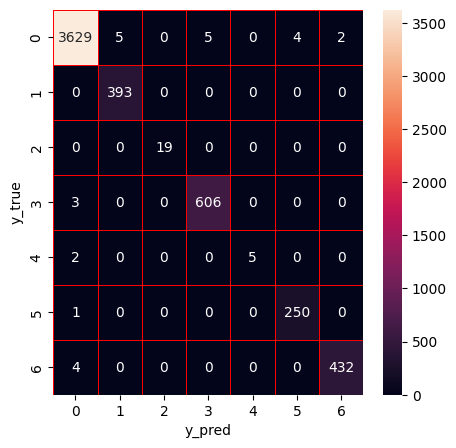

In [43]:
xg = xgb.XGBClassifier(learning_rate= 0.19229249758051492, n_estimators = 30, max_depth = 36)
xg.fit(x_train,y_train)
xg_score=xg.score(x_test,y_test)
y_predict=xg.predict(x_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [44]:
df=pd.read_csv('./data/CICIDS2017_sample_km.csv')

In [45]:
df.Label.value_counts()

Label
0    18225
3     3042
6     2180
1     1966
5     1255
2       96
4       36
Name: count, dtype: int64

In [46]:
df1 = df[df['Label'] != 5]
df1['Label'][df1['Label'] > 0] = 1
df1.to_csv('./data/CICIDS2017_sample_km_without_portscan.csv',index=0)

In [47]:
df2 = df[df['Label'] == 5]
df2['Label'][df2['Label'] == 5] = 1
df2.to_csv('./data/CICIDS2017_sample_km_portscan.csv',index=0)

In [48]:
df1 = pd.read_csv('./data/CICIDS2017_sample_km_without_portscan.csv')
df2 = pd.read_csv('./data/CICIDS2017_sample_km_portscan.csv')

In [49]:
features = df1.drop(['Label'],axis=1).dtypes[df1.dtypes != 'object'].index
df1[features] = df1[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
df2[features] = df2[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
df1 = df1.fillna(0)
df2 = df2.fillna(0)

In [50]:
df1.Label.value_counts()

Label
0    18225
1     7320
Name: count, dtype: int64

In [51]:
df2.Label.value_counts()

Label
1    1255
Name: count, dtype: int64

In [52]:
df2p=df1[df1['Label']==0]
df2pp=df2p.sample(n=None, frac=1255/18225, replace=False, weights=None, random_state=None, axis=0)
df2=pd.concat([df2, df2pp])

In [53]:
df2.Label.value_counts()

Label
1    1255
0    1255
Name: count, dtype: int64

In [54]:
df = pd.concat([df1, df2], ignore_index=True)

In [55]:
X = df.drop(['Label'],axis=1) .values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)
pd.Series(y).value_counts()

0    19480
1     8575
Name: count, dtype: int64

In [56]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X, y)

In [57]:
# calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [58]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break        

In [59]:
X_fs = df[fs].values

In [60]:
X_fs.shape

(28055, 50)

In [61]:
X_fs

array([[-0.34612159, -0.27787307, -0.44364535, ..., -0.13353417,
        -0.05349902, -0.09211243],
       [-0.3443274 , -0.27787307, -0.44364535, ..., -0.13353417,
        -0.05349902, -0.09211243],
       [-0.3443274 , -0.27787307, -0.44364535, ..., -0.13353417,
        -0.05349902, -0.09211243],
       ...,
       [-0.36859622, -0.27651858, -0.36726877, ..., -0.13353417,
        -0.05349902, -0.09211243],
       [-0.36859622, -0.27760477, -0.40965309, ..., -0.13353417,
        -0.04188076, -0.09211243],
       [ 2.77643493, -0.27787307, -0.44364535, ..., -0.13353417,
        -0.05349902, -0.09211243]])

In [62]:
from FCBF_module import FCBF, FCBFK, FCBFiP, get_i
fcbf = FCBFK(k = 20)
#fcbf.fit(X_fs, y)

In [63]:
X_fss = fcbf.fit_transform(X_fs,y)

In [64]:
X_fss.shape

(28055, 20)

In [65]:
X_fss

array([[-0.34612159, -0.53319222, -0.34935843, ..., -0.42229765,
        -0.2803002 , -0.41947688],
       [-0.3443274 , -0.54906516, -0.34935843, ..., -0.42229765,
        -0.2803002 , -0.41947688],
       [-0.3443274 , -0.55544206, -0.34935843, ..., -0.42229765,
        -0.2803002 , -0.41947688],
       ...,
       [-0.36859622, -0.56375976, -0.34935843, ..., -0.42229765,
        -0.2803002 , -0.34937909],
       [-0.36859622, -0.56375976, -0.34935843, ..., -0.42229765,
        -0.2803002 , -0.37957506],
       [ 2.77643493, -0.55932365, -0.34935843, ..., -0.42229765,
        -0.2803002 , -0.42271216]])

In [66]:
#from sklearn.decomposition import KernelPCA
#kpca = KernelPCA(n_components = 10, kernel = 'rbf')
#kpca.fit(X_fss, y)
#X_kpca = kpca.transform(X_fss)

import pandas as pd
from sklearn.decomposition import KernelPCA

# Convert NumPy array to Pandas DataFrame
X_fss_df = pd.DataFrame(X_fss)

# Reduce dataset size
X_sample = X_fss_df.sample(n=5000, random_state=42).values  # Convert back to NumPy array

# Apply Kernel PCA
kpca = KernelPCA(n_components=10, kernel='rbf')
kpca.fit(X_sample)
X_kpca = kpca.transform(X_fss)  # Transform the full dataset



# from sklearn.decomposition import PCA
# kpca = PCA(n_components = 10)
# kpca.fit(X_fss, y)
# X_kpca = kpca.transform(X_fss)

In [67]:
X_train = X_kpca[:len(df1)]
y_train = y[:len(df1)]
X_test = X_kpca[len(df1):]
y_test = y[len(df1):]

In [68]:
pd.Series(y_train).value_counts()

0    18225
1     7320
Name: count, dtype: int64

In [69]:
from imblearn.over_sampling import SMOTE
# Create SMOTE instance without n_jobs
smote = SMOTE(sampling_strategy={1: 18225})
# Apply SMOTE to balance the dataset
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [70]:
pd.Series(y_train).value_counts()

0    18225
1     7320
Name: count, dtype: int64

In [71]:
pd.Series(y_test).value_counts()

1    1255
0    1255
Name: count, dtype: int64

In [72]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN,MeanShift
from sklearn.cluster import SpectralClustering,AgglomerativeClustering,AffinityPropagation,Birch,MiniBatchKMeans,MeanShift 
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics import classification_report
from sklearn import metrics

In [73]:
def CL_kmeans(X_train, X_test, y_train, y_test,n,b=100):
    km_cluster = MiniBatchKMeans(n_clusters=n,batch_size=b)
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    print(classification_report(y_test, result2))
    cm=confusion_matrix(y_test,result2)
    acc=metrics.accuracy_score(y_test,result2)
    print(str(acc))
    print(cm)

In [74]:
CL_kmeans(X_train, X_test, y_train, y_test, 8)

              precision    recall  f1-score   support

           0       0.49      0.95      0.64      1255
           1       0.00      0.00      0.00      1255

    accuracy                           0.47      2510
   macro avg       0.24      0.47      0.32      2510
weighted avg       0.24      0.47      0.32      2510

0.47250996015936253
[[1186   69]
 [1255    0]]


In [75]:
#Hyperparameter optimization by BO-GP
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from sklearn import metrics

space  = [Integer(2, 50, name='n_clusters')]
@use_named_args(space)
def objective(**params):
    km_cluster = MiniBatchKMeans(batch_size=100, **params)
    n=params['n_clusters']
    
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    cm=metrics.accuracy_score(y_test,result2)
    print(str(n)+" "+str(cm))
    return (1-cm)
from skopt import gp_minimize
import time
t1=time.time()
res_gp = gp_minimize(objective, space, n_calls=20, random_state=0)
t2=time.time()
print(t2-t1)
print("Best score=%.4f" % (1-res_gp.fun))
print("""Best parameters: n_clusters=%d""" % (res_gp.x[0]))

30 0.4788844621513944
43 0.47729083665338645
43 0.4681274900398406
43 0.47330677290836654
32 0.4832669322709163
20 0.48366533864541833
16 0.4828685258964143
5 0.47370517928286854
15 0.4944223107569721
25 0.4856573705179283
11 0.4749003984063745
14 0.47370517928286854
50 0.4900398406374502
2 0.5
3 0.5
49 0.47290836653386453
33 0.48167330677290837
4 0.4713147410358566
24 0.48406374501992033
26 0.4828685258964143
12.913047790527344
Best score=0.5000
Best parameters: n_clusters=2


In [76]:
#Hyperparameter optimization by BO-TPE
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics

def objective(params):
    params = {
        'n_clusters': int(params['n_clusters']), 
    }
    km_cluster = MiniBatchKMeans(batch_size=100, **params)
    n=params['n_clusters']
    
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    score=metrics.accuracy_score(y_test,result2)
    print(str(params['n_clusters'])+" "+str(score))
    return {'loss':1-score, 'status': STATUS_OK }
space = {
    'n_clusters': hp.quniform('n_clusters', 2, 50, 1),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

22 0.48446215139442234                                                                                                 
20 0.47729083665338645                                                                                                 
45 0.4784860557768924                                                                                                  
7 0.4709163346613546                                                                                                   
37 0.4820717131474104                                                                                                  
24 0.4860557768924303                                                                                                  
41 0.47410358565737054                                                                                                 
36 0.4824701195219124                                                                                                  
3 0.4717131474103586                    

In [77]:
CL_kmeans(X_train, X_test, y_train, y_test, 16)

              precision    recall  f1-score   support

           0       0.48      0.92      0.63      1255
           1       0.00      0.00      0.00      1255

    accuracy                           0.46      2510
   macro avg       0.24      0.46      0.31      2510
weighted avg       0.24      0.46      0.31      2510

0.4593625498007968
[[1153  102]
 [1255    0]]


In [78]:
# Only a sample code to show the logic. It needs to work on the entire dataset to generate sufficient training samples for biased classifiers
def Anomaly_IDS(X_train, X_test, y_train, y_test,n,b=100):
    # CL-kmeans
    km_cluster = MiniBatchKMeans(n_clusters=n,batch_size=b)
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    print(classification_report(y_test, result2))
    cm=confusion_matrix(y_test,result2)
    acc=metrics.accuracy_score(y2,result2)
    print(str(acc))
    print(cm)
    
    #Biased classifier construction
    count=0
    print(len(y))
    a=np.zeros(n)
    b=np.zeros(n)
    FNL=[]
    FPL=[]
    for v in range(0,n):
        al=[]
        bl=[]
        for i in range(0,len(y)):   
            if result[i]==v:        
                if y[i]==1:        #label 1
                    a[v]=a[v]+1
                    al.append(i)
                else:             #label 0
                    b[v]=b[v]+1
                    bl.append(i)
        if a[v]<=b[v]:
            FNL.extend(al)
        else:
            FPL.extend(bl)
        #print(str(v)+"="+str(a[v]/(a[v]+b[v])))
        
    dffp=df.iloc[FPL, :]
    dffn=df.iloc[FNL, :]
    dfva0=df[df['Label']==0]
    dfva1=df[df['Label']==1]
    
    dffpp=dfva1.sample(n=None, frac=len(FPL)/dfva1.shape[0], replace=False, weights=None, random_state=None, axis=0)
    dffnp=dfva0.sample(n=None, frac=len(FNL)/dfva0.shape[0], replace=False, weights=None, random_state=None, axis=0)
    
    dffp_f=pd.concat([dffp, dffpp])
    dffn_f=pd.concat([dffn, dffnp])
    
    Xp = dffp_f.drop(['Label'],axis=1)  
    yp = dffp_f.iloc[:, -1].values.reshape(-1,1)
    yp=np.ravel(yp)

    Xn = dffn_f.drop(['Label'],axis=1)  
    yn = dffn_f.iloc[:, -1].values.reshape(-1,1)
    yn=np.ravel(yn)
    
    rfp = RandomForestClassifier(random_state = 0)
    rfp.fit(Xp,yp)
    rfn = RandomForestClassifier(random_state = 0)
    rfn.fit(Xn,yn)

    dffnn_f=pd.concat([dffn, dffnp])
    
    Xnn = dffn_f.drop(['Label'],axis=1)  
    ynn = dffn_f.iloc[:, -1].values.reshape(-1,1)
    ynn=np.ravel(ynn)

    rfnn = RandomForestClassifier(random_state = 0)
    rfnn.fit(Xnn,ynn)

    X2p = df2.drop(['Label'],axis=1) 
    y2p = df2.iloc[:, -1].values.reshape(-1,1)
    y2p=np.ravel(y2p)

    result2 = km_cluster.predict(X2p)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y)):
            if result[i]==v:
                if y[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    l1=[]
    l0=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y2p)):
        if result2[v] in list1:
            result2[v]=0
            l0.append(v)
        elif result2[v] in list2:
            result2[v]=1
            l1.append(v)
        else:
            print("-1")
    print(classification_report(y2p, result2))
    cm=confusion_matrix(y2p,result2)
    print(cm)